In [2]:
from google.colab import files

uploaded = files.upload()


Saving test.tsv to test.tsv
Saving train.tsv to train.tsv
Saving valid.tsv to valid.tsv


In [3]:
import pandas as pd

# Load datasets separately with correct headers
train = pd.read_csv("train.tsv", sep='\t', header=0)
test = pd.read_csv("test.tsv", sep='\t', header=0)
valid = pd.read_csv("valid.tsv", sep='\t', header=0)

# Check that columns are now correct
print("Train Columns:", train.columns.tolist())
print(train.head())


Train Columns: ['2635.json', 'false', 'Says the Annies List political group supports third-trimester abortions on demand.', 'abortion', 'dwayne-bohac', 'State representative', 'Texas', 'republican', '0', '1', '0.1', '0.2', '0.3', 'a mailer']
    2635.json        false  \
0  10540.json    half-true   
1    324.json  mostly-true   
2   1123.json        false   
3   9028.json    half-true   
4  12465.json         true   

  Says the Annies List political group supports third-trimester abortions on demand.  \
0  When did the decline of coal start? It started...                                   
1  Hillary Clinton agrees with John McCain "by vo...                                   
2  Health care reform legislation is likely to ma...                                   
3  The economic turnaround started at the end of ...                                   
4  The Chicago Bears have had more starting quart...                                   

                             abortion    dwayne-

In [ ]:
import pandas as pd

# Manually define the correct column names based on your description
column_names = [
    'id', 'label', 'statement', 'subjects', 'speaker', 'speaker_job',
    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'true_counts', 'context'
]

# Load train.tsv WITHOUT using the first row as header
train = pd.read_csv("train.tsv", sep='\t', header=None, names=column_names)

# Check if the dataframe looks right now
print("Train Data:")
print(train.head())
print("\nColumn Names:")
print(train.columns.tolist())


Train Data:
           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                             subjects         speaker           speaker_job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

  state_info party_affilia

**Distribution of labels**

<ipython-input-24-4900263cc9e2>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='label', order=train['label'].value_counts().index, palette='viridis')


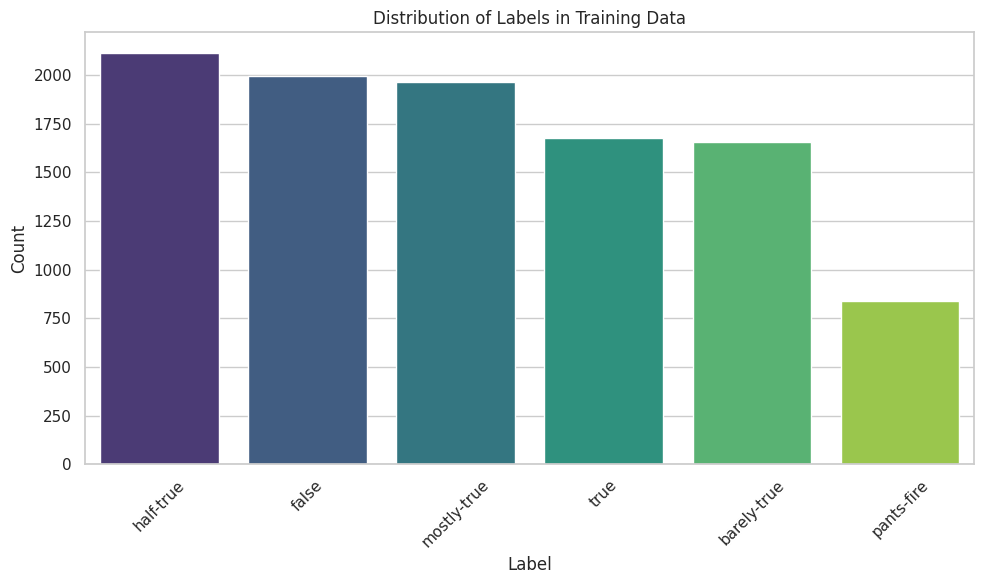

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set(style="whitegrid")

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='label', order=train['label'].value_counts().index, palette='viridis')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Basic Cleaning and Lowercasing

In [ ]:
import re

def clean_text(text):
    if pd.isnull(text):
        return ""
    # Remove non-alphabetic characters (keep basic punctuation if needed)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply to the 'statement' column
train['clean_statement'] = train['statement'].apply(clean_text)


Encode Labels into Numerical Format

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train['label_encoded'] = label_encoder.fit_transform(train['label'])

# To check encoding
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'barely-true': np.int64(0), 'false': np.int64(1), 'half-true': np.int64(2), 'mostly-true': np.int64(3), 'pants-fire': np.int64(4), 'true': np.int64(5)}


In [ ]:
# Fill missing values with 'unknown'
train.fillna({
    'speaker': 'unknown',
    'speaker_job': 'unknown',
    'state_info': 'unknown',
    'party_affiliation': 'unknown',
    'context': 'unknown',
}, inplace=True)


Computing Credibity Score

In [ ]:
def compute_credibility(row):
    true = row['true_counts']
    mostly_true = row['mostly_true_counts']
    half_true = row['half_true_counts']
    total = (row['barely_true_counts'] + row['false_counts'] +
             half_true + mostly_true + true)

    if total == 0:
        return 0.0
    credibility = (true + mostly_true + half_true) / total
    return credibility

# Apply to each row
train['credibility_score'] = train.apply(compute_credibility, axis=1)

# Preview
train[['speaker', 'credibility_score']].head()


,speaker,credibility_score
0,dwayne-bohac,0.000000
1,scott-surovell,1.000000
2,barack-obama,0.701903
3,blog-posting,0.666667
4,charlie-crist,0.630769


In [ ]:
import networkx as nx

# Initialize graph
G = nx.Graph()

# Add speaker-topic edges
for _, row in train.iterrows():
    speaker = row['speaker']
    topics = row['subjects']

    # Skip if missing data
    if pd.isna(speaker) or pd.isna(topics):
        continue

    # Split topics and add edges
    for topic in topics.split(','):
        G.add_node(speaker, bipartite='speaker')
        G.add_node(topic.strip(), bipartite='topic')
        G.add_edge(speaker, topic.strip())

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph created with 3052 nodes and 14095 edges.


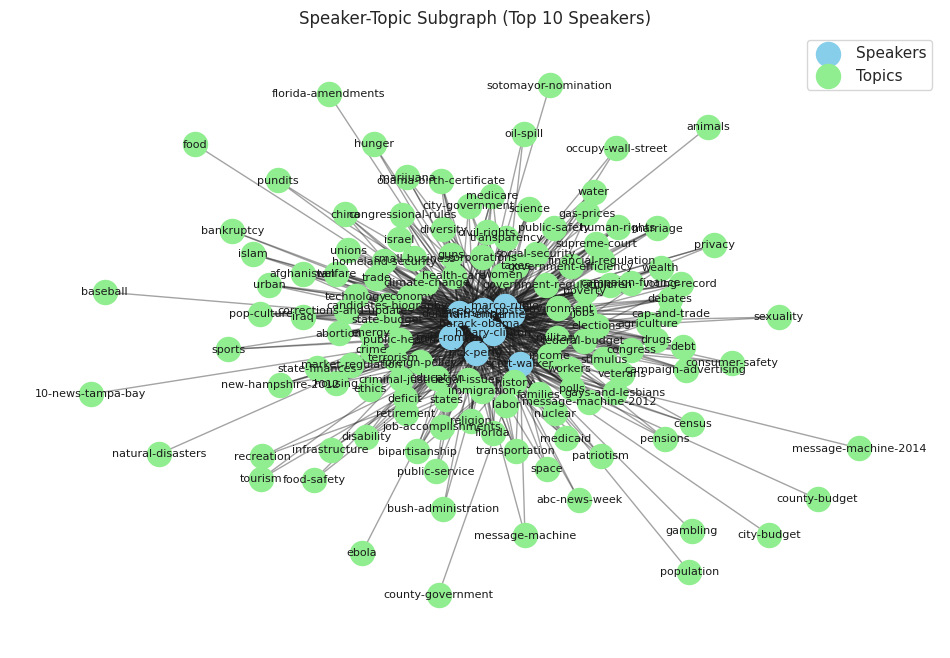

In [ ]:
import matplotlib.pyplot as plt

# Get top N most connected speakers
top_speakers = sorted([n for n in G.nodes if G.nodes[n]['bipartite'] == 'speaker'],
                      key=lambda n: G.degree(n), reverse=True)[:10]

# Get their immediate neighbors (topics)
top_nodes = set(top_speakers)
for speaker in top_speakers:
    top_nodes.update(G.neighbors(speaker))

# Create subgraph
subG = G.subgraph(top_nodes)

# Position nodes using spring layout
pos = nx.spring_layout(subG, seed=42)

# Draw speakers and topics with different colors
speaker_nodes = [n for n in subG.nodes if subG.nodes[n]['bipartite'] == 'speaker']
topic_nodes = [n for n in subG.nodes if subG.nodes[n]['bipartite'] == 'topic']

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(subG, pos, nodelist=speaker_nodes, node_color='skyblue', label='Speakers')
nx.draw_networkx_nodes(subG, pos, nodelist=topic_nodes, node_color='lightgreen', label='Topics')
nx.draw_networkx_edges(subG, pos, alpha=0.4)
nx.draw_networkx_labels(subG, pos, font_size=8)

plt.title("Speaker-Topic Subgraph (Top 10 Speakers)")
plt.legend()
plt.axis('off')
plt.show()


In [ ]:
import networkx as nx
import pandas as pd

# Apply PageRank on the full graph G
pagerank_scores = nx.pagerank(G, alpha=0.85)

# Filter only speaker nodes based on bipartite attribute
speaker_scores = {
    node: score
    for node, score in pagerank_scores.items()
    if G.nodes[node].get("bipartite") == "speaker"
}

# Convert to DataFrame
pagerank_df = pd.DataFrame(list(speaker_scores.items()), columns=['speaker', 'pagerank_score'])

# Sort and show
pagerank_df = pagerank_df.sort_values(by='pagerank_score', ascending=False).reset_index(drop=True)
print(pagerank_df.head(10))


           speaker  pagerank_score
0  hillary-clinton        0.002504
1     barack-obama        0.002482
2     donald-trump        0.002439
3   facebook-posts        0.002003
4     scott-walker        0.001972
5      marco-rubio        0.001967
6       rick-perry        0.001958
7      chain-email        0.001888
8      mitt-romney        0.001784
9         ted-cruz        0.001738


Adding PageReank Score to train dataset

In [ ]:
# Merge pagerank
train = train.merge(pagerank_df, on='speaker', how='left')
train['pagerank_score'] = train['pagerank_score'].fillna(0)


Visualize Top Speakers by PageRank and Credibility

<ipython-input-33-fbb121bad98c>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar.set_xticklabels(bar.get_xticklabels(), rotation=45, ha='right')


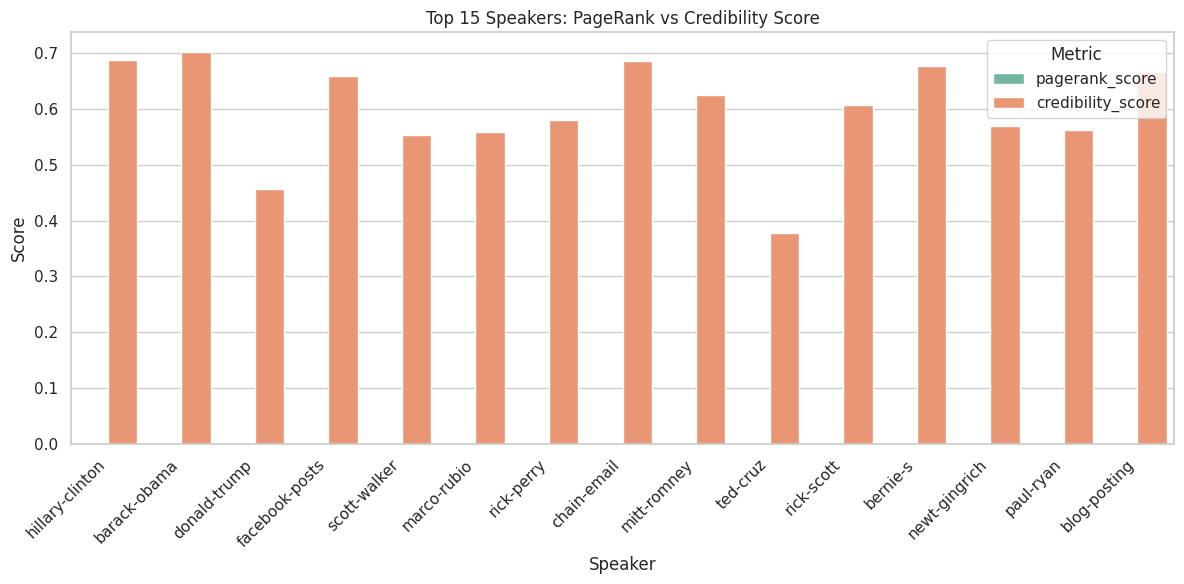

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge PageRank and credibility scores (already done earlier)
merged_df = train[['speaker', 'credibility_score', 'pagerank_score']].dropna()
merged_df = merged_df.groupby('speaker', as_index=False).mean()

# Get Top 15 speakers by PageRank
top_speakers = merged_df.sort_values(by='pagerank_score', ascending=False).head(15)

# Plot PageRank and Credibility side by side
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Barplot with both scores
bar = sns.barplot(data=top_speakers.melt(id_vars='speaker',
                                          value_vars=['pagerank_score', 'credibility_score']),
                  x='speaker', y='value', hue='variable', palette='Set2')

bar.set_title('Top 15 Speakers: PageRank vs Credibility Score')
bar.set_ylabel('Score')
bar.set_xlabel('Speaker')
bar.set_xticklabels(bar.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.legend(title="Metric")
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorizer for 'clean_statement'
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(train['clean_statement'])

# Convert credibility and pagerank scores to arrays
import numpy as np
credibility = np.array(train['credibility_score']).reshape(-1, 1)
pagerank = np.array(train['pagerank_score'].fillna(0)).reshape(-1, 1)  # fill NaN with 0

# Combine all features
from scipy.sparse import hstack
X = hstack([X_text, credibility, pagerank])

# Labels (make sure you already have label mapping like: {'false':1, ...})
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}

y = train['label'].map(label_map)
# Check shape of feature matrix
print("Feature matrix X shape:", X.shape)

# Check some values of y
print("Sample labels y:", y[:10].tolist())

# Optional: Check TF-IDF feature names
print("TF-IDF Sample Features:", tfidf.get_feature_names_out()[:10])


Feature matrix X shape: (10240, 5002)
Sample labels y: [0, 1, 1, 0, 1, 1, 0, 1, 1, 1]
TF-IDF Sample Features: ['aaa' 'aaron' 'aarp' 'abandoned' 'abbas' 'abbott' 'abc' 'abele' 'abide'
 'abilities']


Split the Data and Encode Labels

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels (just in case they aren't already numeric)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Label distribution in train:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Label distribution in test:", dict(zip(*np.unique(y_test, return_counts=True))))


Train set size: (8192, 5002)
Test set size: (2048, 5002)
Label distribution in train: {np.int64(0): np.int64(3590), np.int64(1): np.int64(4602)}
Label distribution in test: {np.int64(0): np.int64(898), np.int64(1): np.int64(1150)}


In [ ]:
from sklearn.impute import SimpleImputer

# Impute NaNs (though TF-IDF usually shouldn’t have NaNs)
imputer = SimpleImputer(strategy="constant", fill_value=0)

# Convert sparse matrix to dense just for imputation
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:471: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit model on training data
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Check if it worked
print("Model training and prediction complete!")


Model training and prediction complete!


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", accuracy)

# Precision, Recall, F1-Score (macro-average handles multiclass)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("✅ Precision (macro):", precision)
print("✅ Recall (macro):", recall)
print("✅ F1 Score (macro):", f1)

# Full Classification Report
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy: 0.68896484375
✅ Precision (macro): 0.6842698315053489
✅ Recall (macro): 0.67838772150673
✅ F1 Score (macro): 0.6797718154247963

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.59      0.63       898
           1       0.71      0.76      0.73      1150

    accuracy                           0.69      2048
   macro avg       0.68      0.68      0.68      2048
weighted avg       0.69      0.69      0.69      2048


🧩 Confusion Matrix:
 [[532 366]
 [271 879]]


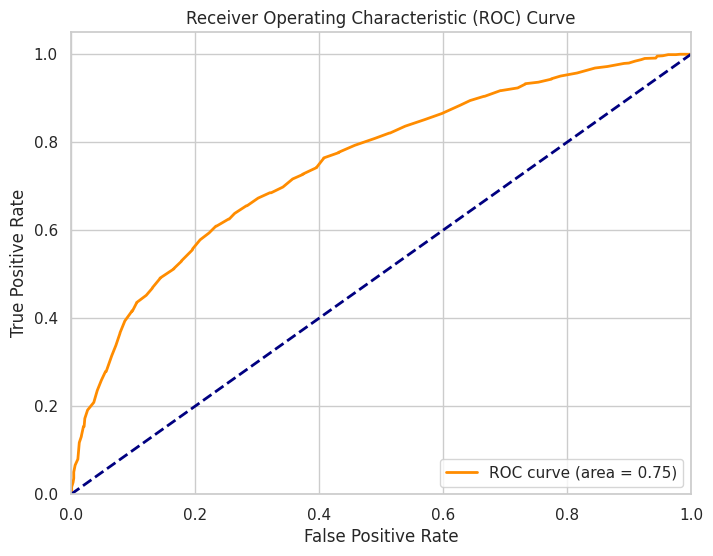

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_pred are already defined as per your code
# Get predicted probabilities for the positive class (class 1)
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Use your model to predict probabilities

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


The ROC curve shows that your model has a good ability to distinguish between classes, with an AUC of 0.75, meaning it correctly identifies positives and negatives 75% of the time. It's clearly better than random guessing, but there's still room for improvement.